In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch


device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
from pathlib import Path
import pickle

from thera_panacea.utils import get_class_weights

with open(Path("data/cleaned_df.pkl"), "rb") as f:
    cleaned_df_ = pickle.load(f)

cleaned_df = cleaned_df_[["path", "label"]]

class_weight = get_class_weights(cleaned_df, device)

In [8]:
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm import tqdm

from thera_panacea.dataset.dataset import TherasDS
from thera_panacea.model.baseline_model import BaselineModel, preprocess
from thera_panacea.trainer.trainer import Trainer
from torch.nn import CrossEntropyLoss


n_epochs = 20
batch_size = 2048
epochs = range(1, n_epochs + 1)

model = BaselineModel().to(device)
opt = Adam(model.parameters())

train_ds = TherasDS(cleaned_df, device, preprocess)
train_dl = DataLoader(train_ds, batch_size=batch_size)

best_hter = 0.5
hter_not_improving_count = 0


model_path = Path("final_model_state_dict.pth")

loss_function = CrossEntropyLoss(
    weight=class_weight,
    label_smoothing=0.1
)
trainer = Trainer(model, opt, loss_function)

# Training
model.train()
for epoch in epochs:
    print(f"Epoch {epoch} / {n_epochs}")
    for imgs, labels in tqdm(train_dl):
        trainer.fit(imgs, labels)

torch.save(model.state_dict(), model_path)

Epoch 1 / 20


  4%|▍         | 2/47 [00:05<01:58,  2.62s/it]


KeyboardInterrupt: 

In [5]:
from thera_panacea.etl.extract import extract_to_df


val_df = extract_to_df(Path("data/val_img"))
val_ds = TherasDS(val_df, device, preprocess)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [6]:
model.eval()

preds = []
for imgs in tqdm(val_dl):
    pred = model(imgs).argmax(-1)
    preds.extend(pred.cpu().numpy())

val_df["pred"] = preds
val_df.head()

100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


,path,pred
0,data/val_img/000001.jpg,1
1,data/val_img/000002.jpg,0
2,data/val_img/000003.jpg,1
3,data/val_img/000004.jpg,1
4,data/val_img/000005.jpg,1


In [14]:
with open(Path("val_df.pkl"), "wb") as f:
    pickle.dump(val_df, f)

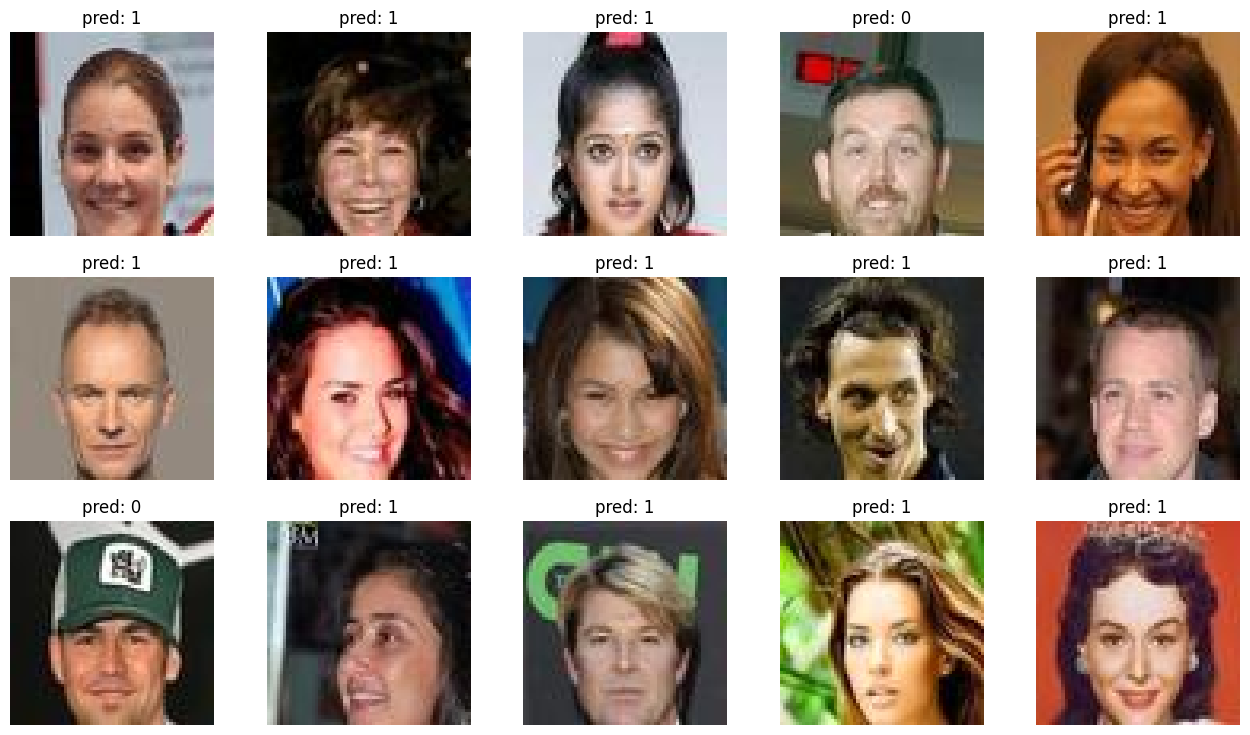

In [11]:
import matplotlib.pyplot as plt
from PIL import Image


n_rows = 3
n_cols = 5
sample_val = val_df.sample(15)
fig, axes = plt.subplots(n_rows, n_cols)

fig.set_size_inches(16, 9)

for i in range(n_rows):
    for j in range(n_cols):
        ax: plt.Axes = axes[i, j]
        idx = i * n_cols + j
        img_path, pred = sample_val.iloc[idx]
        with Image.open(img_path) as img:
            ax.imshow(img)
        ax.set_title(f"pred: {pred}")
        ax.set_axis_off()

In [13]:
with open("label_val.txt", "w") as f:
    txt_preds = "\n".join(str(pred) for pred in preds)
    f.write(txt_preds)